[Chapter 5] Pretraining on unlabeled data

In [19]:
import torch 
import import_ipynb
from ch4 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,  # shorten the context length from 1024 to 256
                            # reduces the computational demand of training the model
                            # making it possible to carry out the training on a standard laptop PC
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,      # it's possible and common to set dropout to 0
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [20]:
import tiktoken
from ch4 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("output text:\n", token_ids_to_text(token_ids, tokenizer))

output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


calculating text generation loss

In [21]:
inputs = torch.tensor([[16833, 3626, 6100],  # every effort moves
                       [40, 1107, 588]])     # i really like

# targets are the inputs but shifted one position forward
targets = torch.tensor([[3626, 6100, 345],   # effort moves you
                        [1107, 588, 11311]]) # really like chocolates

with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

# 2 - batch size (given 2 examples in the inputs)
# 3 - # of tokens in each input(row)
# 50257 - embedding dimensionality, determined by vocab size

torch.Size([2, 3, 50257])


In [22]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("token ids:\n", token_ids)

# given 2 input batches, each with 3 tokens, yields 2 sets of outputs, each with 3 predicted token IDs

token ids:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [23]:
print(f"targets batch 1:  {token_ids_to_text(targets[0], tokenizer)}")
print(f"outputs batch 1: "
      f"{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

targets batch 1:   effort moves you
outputs batch 1:  Armed heNetflix


In [24]:
# initial softmax prob

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("text 1: ", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("text 2: ", target_probas_2)

# the goal of training an LLM is to maximize the likelihood of the correct token (increasing its prob relative to other tokens)

text 1:  tensor([    0.0001,     0.0000,     0.0000])
text 2:  tensor([    0.0000,     0.0001,     0.0000])


In [25]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

# working with logarithms of probability scores is more manageable in mathematical opimization than handling the scores directly

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [26]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

# the goal is to get the avg log prob as close to 0 as possible by updating te model's weight as part of the training process (backpropagation)
# in deep learning, the common practice isn't to push the average log prob up to 0 but rather to bring the -ve avg log prob down to 0

neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

# cross entropy: the term for turning the -ve value -10.x into +10.x
# pytorch has built-in cross_entropy function

print("logits shape: ", logits.shape)
print("targets shape: ", targets.shape)

tensor(-10.7940)
tensor(10.7940)
logits shape:  torch.Size([2, 3, 50257])
targets shape:  torch.Size([2, 3])


In [27]:
logits_flat = logits.flatten(0, 1) # unscaled model outputs before they enter the softmax function to obtain prob scores
targets_flat = targets.flatten()   # the token IDs we want the LLMs to generate
print("flattened logits: ", logits_flat.shape)
print("flattened targets: ", targets_flat.shape)

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

# perplexity measure how well the prob distribution predicted by the model matches the actual distribution of the words in the dataset
# the lower the closer to actual distribution
# considered more interpretable than the raw loss because it signifies the effective vocab size
# 49064: model being unsure about which among 49064 tokens in the vocab to generate as the next token
perplexity = torch.exp(loss)
print(perplexity)

flattened logits:  torch.Size([6, 50257])
flattened targets:  torch.Size([6])
tensor(10.7940)
tensor(48725.8203)


calculating the training and validation set losses

In [28]:
file_path = "the-verdict.txt"

with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [29]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("characters:", total_characters)
print("tokens:", total_tokens) #5145 is too small to train, for educational purpose only

characters: 20479
tokens: 5145


In [30]:
train_ratio = 0.90 # define 90% training data and the remaining 10% as validation data
split_idx = int(train_ratio * len(text_data))
train_data = text_data[: split_idx]
val_data = text_data[split_idx:]

In [31]:
import import_ipynb
from ch2 import create_dataloader_v1

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0   
)

print("train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nvalidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

# batch size = 2: we used small batch size to reduce computational resource demand because we were working with a very small dataset.
#                 in practice, training LLMs with batch sizes of 1024 or larger is not uncommon.
# 9 training set batches (2 samples and 256 tokens each) and 1 validation set (2 input examples and 256 tokens)


train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [32]:
# compute the loss for a single batch

def calc_loss_batch(input_batch, target_batch, model, device):
    # the transfer to a given device allows us to transfer the data to a GPU
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss


In [ ]:
# compute the loss over all the batches sampled by a given data loader
# num_batches: we can specify a smallre num_batches to speed up the evaluation during model training
def calc_loss_loader(data_loader, model, device, num_batches=None):
    
    total_loss = 0.
    
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None: 
        #iteratives over all batches if no fixed num_batches is specified
        num_batches = len(data_loader)
    else:
        # reduces the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device 
            )
            # sums loss for each batch
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches  #average the loss over all batches

In [34]:
# if machine with cuda-supported gpu, the LLM will train on the gpu without making any change to the code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# disable gradient tracking for efficiency because we are not training yet
with torch.no_grad():
    # ensure the data is loaded onto the same device as LLM model via "device" setting
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("training loss:", train_loss)
print("validation loss:", val_loss)

# the loss values are relatively high because the model has not yet been trained
# for comparison, the loss approaches 0 if the model learns to generate the text tokens as they appear in the training and validation sets

training loss: 10.987583584255642
validation loss: 10.981106758117676


training an LLM

In [35]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs, 
                       eval_freq, eval_iter, start_context, tokenizer):
    # initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # start the main training loop (1 epoch is 1 complete pass over a training set)
    for epoch in range(num_epochs):

        model.train()

        for input_batch, target_batch in train_loader:
            # reset loss gradients from the previous batch iteration
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            # calculate loss gradients
            loss.backward()
            # update model weights using loss gradients
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            # optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step: 06d}):"
                      f"train loss {train_loss: .3f} ," 
                      f"val loss {val_loss: .3f}"
                      )
        
        # print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen    


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    # print the training and validation set losses after each model update
    # so we can evaluate whether the training improves the model

    # dropout is disabled during evaluation for stable and reproducible results
    model.eval()

    # disables graident tracking, which is not required during evauation, to reduce the computational overhead
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    # take a text snippet(start_context) as input, feeds it to the LLM to generate a text sample using generate_text_simple
    # also a convenience function used to track whether the model imporves during the training
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n",""))
    model.train()

In [36]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
# AdamW optimizer: improves the weight decay approach, to minimize model complexity and prevent overfitting by penalizing larger weights
# frequently used in the traning of LLMs
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,
    weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses,tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)


Ep 1 (Step  00000):train loss  9.781 ,val loss  9.933
Ep 1 (Step  00005):train loss  8.111 ,val loss  8.339
Every effort moves you,,,,,,,,,,,,.
Ep 2 (Step  00010):train loss  6.661 ,val loss  7.048
Ep 2 (Step  00015):train loss  5.961 ,val loss  6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step  00020):train loss  5.726 ,val loss  6.600
Ep 3 (Step  00025):train loss  5.201 ,val loss  6.348
Every effort moves you, and I had been.
Ep 4 (Step  00030):train loss  4.417 ,val loss  6.278
Ep 4 (Step  00035):train loss  4.069 ,val loss  6.226
Every effort moves you know the"I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step  00040):train loss  3.732 ,val loss  6.160
Every effort moves you know it was not that the picture--I had the fact by the last I had been--his, and in the"Oh, and he said, and down the room, and in
Ep 6 (Step  00045):train l

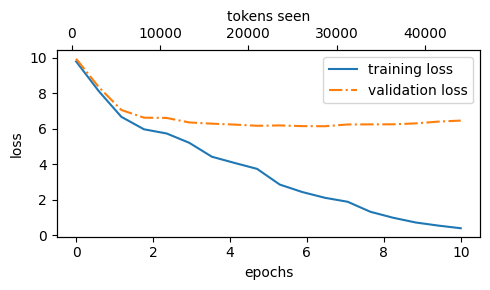

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label='training loss')
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="validation loss")
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

decoding strategies to control randomness

In [38]:
# put the model into evaluation mode to turn off random components (such as dropout)
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [61]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("output text:\n", token_ids_to_text(token_ids, tokenizer))

output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [40]:
# temperature scaling (probabilistic sampling)

vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [41]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

# since the largest logit is 6.75 (pos=3), the generated word is "forward" based on vocab

forward


In [42]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

# "forward" is still the most likely token and will be selected by multinomial most of time but not all the time
# this means if we use multinomial (not argmax) function inside the generate_and_print_sample, the LLM would sometimes generate texts
# such as every effort moves you "toward"

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [43]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# temperature greater than 1 will result in more uniformly distributed token probabilities
#             smaller than 1 will result in more confident (sharper/peaky) distributions

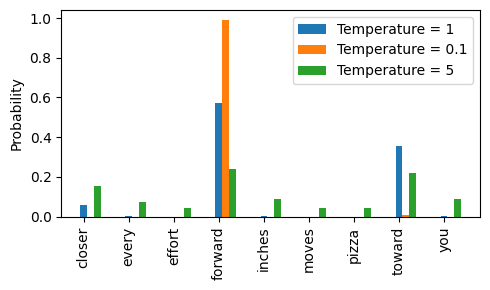

In [44]:
temperatures = [1, 0.1, 5] #original, lower, higher
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar( x + i*bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# temp=0.1 results in sharper distribution such that multinomial selects "forward" almost 100% of the time (close to argmax)
# temp=5 results in more uniform distribution where other tokens are selected more often 
#         (add more variety to generated text, but also more often results in nonsensical text)

In [45]:
# top-k approach replaces all nonselected logits with negative infinity values (-inf), 
# for which prob score of 0 when computing softmax and the remaining prob sum up to 1 
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("top logits:", top_logits)
print("top positions:", top_pos)


new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)


topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

top logits: tensor([6.7500, 6.2800, 4.5100])
top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [46]:
# modify generate_text_simple by combining temperature sampling and top-k sampling

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, 
             top_k=None, eos_id=None):
    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :] #same with before, gets logits only focus on the last time step

        # filters logits wt top_k sampling
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        
        # apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            # carry out greedy next-token selection as before when temperature scaling is disabled
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [62]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("output text:\n", token_ids_to_text(token_ids, tokenizer))

# the generated text 
# now is different from the one we previously genereated via generate_simple which was a memorized passage from the training set

output text:
 Every effort moves youlit terrace.



" he said deprecating laugh


loading and saving model weights in pytorch

In [48]:
# state_dict is a dict mapping each layer to its parameters
# saving model weights via the state_dict
torch.save(model.state_dict(), "model.pth")

In [49]:
# load model weights into a new GPTModel model
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
# switch the model to evaluation mode for inference, disabling the dropout layers of the model
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [50]:
# save model and optimizer state_dict contents

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [51]:
# load saved data

checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

loading pretrained weights from openai

In [52]:
# openai originally saved the gpt2 weights via tensorflow
import urllib.request

url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch05/"
       "01_main-chapter-code/gpt_download.py")

filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x21aa8ad9820>)

In [53]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size='124M', models_dir="gpt2"
)

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [54]:
print("setttings:", settings)
print("parameter dictionary keys:", params.keys())
print(params['wte'])
print("token embedding weight tensor dimensions:", params['wte'].shape)

setttings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
token embedding weight tensor dimensions: (50257, 768)


In [ ]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-x1 (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [56]:
model_name = 'gpt2-small (124M)'
# update model configuarion
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [57]:
# check if two tensors have the same shape
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                          "Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [58]:
# the GPTModel initialized with random weighs for pretraining
# use openai's model weights to override these random weights

import numpy as np

def load_weights_into_gpt(gpt, params):
    # set the model's positional and token embedding weights to those specified in params
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    # iterates over each transformer block in the model
    for b in range(len(params["blocks"])):
        # np.split function is used to divide the attention and bias weights
        #                   into three equal parts for the query, key and value components

        # the assign function will alert us if we try to match two tensors with different dimensions

        # attention weights
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # bias weights        
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)
        



        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params['blocks'][b]["attn"]["c_proj"]["w"].T)
        
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params['blocks'][b]['attn']['c_proj']['b'])
        



        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params['blocks'][b]['mlp']['c_fc']['w'].T)
        
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params['blocks'][b]['mlp']['c_fc']['b'])
        
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params['blocks'][b]['mlp']['c_proj']['w'].T)
        
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params['blocks'][b]['mlp']['c_proj']['b'])
        



        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params['blocks'][b]['ln_1']['g'])
        
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params['blocks'][b]['ln_1']['b'])

        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params['blocks'][b]['ln_2']['g'])
        
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params['blocks'][b]['ln_2']['b'])
        

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params['g'])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params['b'])
    # weight tying: the original gpt model by openai reused the token embedding weights in the output layer
    #               to reduce the total number of parameters
    gpt.out_head.weight = assign(gpt.out_head.weight, params['wte'])    
        

In [59]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [60]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("output text:\n", token_ids_to_text(token_ids, tokenizer))

# with loaded weights, the model can produce more coherent text now.

output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


